# Ensemble learning

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, RandomForestClassifier

## Zbiór danych

W zadaniu poddany analizie będzie dobrze już znany zbiór MNIST.

In [77]:
mnist = fetch_openml("mnist_784", data_home="./mnist_784", cache=True)

In [78]:
X = mnist.data[:1000]
y = mnist.target[:1000]

## Transformacja zbioru do przestrzeni 30D

In [79]:
standard_scaler = StandardScaler()
X_scaled = standard_scaler.fit_transform(X)

pca = PCA(30)
X_pca = pca.fit_transform(X_scaled)

## Wybór trudno rozdzielalnych cech

W celu znalezienia trudno rozróżnialnych cech zbioru możemy skorzystać z metody t-SNE.

In [80]:
X_embedded = TSNE(n_components=2).fit_transform(X_pca)
X_embedded.shape

(1000, 2)

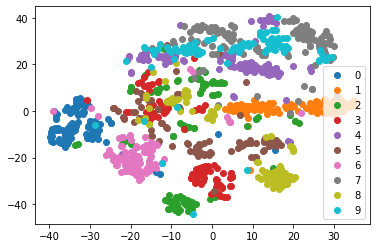

In [81]:
ids = [str(i) for i in range(10)]

for c, label in zip(mcolors.TABLEAU_COLORS, ids):
    plt.scatter(X_embedded[y == label, 0], X_embedded[y == label, 1], c=c, label=label)
plt.legend()
plt.show()

Wyraźnie widać zgrupowanie klasy 4 i 9. Użyjemy ich w dalszej części zadania.

In [82]:
digit_filter = np.where((y == '4') | (y == '9'))
X_filtered, y_filtered = X_pca[digit_filter], y[digit_filter]

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=13)

## Bagging

W zależności od sposobu wyboru podzbiorów zbioru danych wyróżniamy różne rodzaje tego algorytmu:

- **pasting** - wybór losowych podzbiorów próbek
- **bagging** - wybór losowych podzbiorów próbek ze zwracaniem
- **random subspaces** - wybór losowych podzbiorów cech
- **random patches** - wybór losowych podzbiorów próbek i cech

#### Klasyczny bagging

In [123]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        max_samples=0.5).fit(X_train, y_train)

In [103]:
clf.score(X_test, y_test)

0.9512195121951219

#### Random subspace

In [115]:
clf = BaggingClassifier(base_estimator=SVC(),
                        n_estimators=5,
                        bootstrap_features=True,
                        max_features=0.5).fit(X_train, y_train)

In [116]:
clf.score(X_test, y_test)

0.926829268292683

## Random Forest

In [117]:
clf = RandomForestClassifier(n_estimators=5,
                             max_samples=0.5).fit(X_train, y_train)

In [118]:
clf.score(X_test, y_test)

0.8780487804878049

## Ada Boost

In [119]:
clf = AdaBoostClassifier(n_estimators=5).fit(X_train, y_train)

In [120]:
clf.score(X_test, y_test)

0.8536585365853658

### Zadanie

Dla każdego z wyżej przedstawionych klasyfikatorów odpowiedzieć na pytania:

1. Jak zmienia się dokładność klasyfikacji dla wzrastającej liczby klasyfikatrów w zespole i liczby przykładów, na których są one uczone?
2. Jak zmienia się dokładność klasyfikacji dla różnych metod określania finalnej decyzji (majority vote, mean etc.)